## Entropy
Shannon entropy is defined as the logarithm of "the number of states" $1/p(x)$, averaged by probability $p(x)$:
$$ H = \sum_{x} p(x) \log_2 {1 \over p(x)} \tag{1}$$
"The number of states" $1/p$ is actually how many times, on average, you have to flip a bent coin with the probability of heads $p$ to get the first head. I call it "the number of states" to indicate the relationship with the Boltzmann entropy $\ln W$, where $W$ counts the number of ways the atoms or molecules of gases can be arranged. This relationship was pointed out by Shannon and I find it useful.

Another way of writing formula $(1)$ is
$$ H =- \sum_{x} p(x) \log_2 p(x) \tag{2}$$



The logarithm is taken with a base of 2 to measure how many bits (0's or 1's) you need to represent an event $x$ that comes from the distribution $p(x)$.

In the simplest case, when a random variable $x$ has two outcomes like flipping a coin with the probability of heads $p$, the entropy equals
$$ H_2(p) = p \log_2 {1 \over p} + (1-p) \log_2 {1 \over 1-p} \tag{3}$$

Subscript $H_2$ indicates the are only two outcomes. And here is the plot.

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:8: RuntimeWarning: divide by zero encountered in true_divide
  
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:8: RuntimeWarning: invalid value encountered in multiply
  


Text(0, 0.5, 'Entropy H, bits')

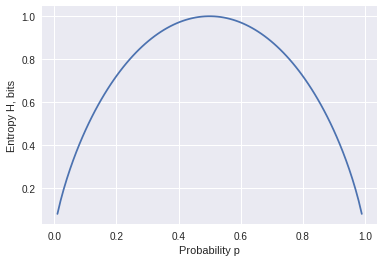

In [0]:
!pip install numpy==1.15.4 matplotlib==3.0.1
%matplotlib inline

import numpy as np
import matplotlib.pyplot as plt

proba = np.linspace(start=0, stop=1, num=100)
entropy = proba * np.log2(1/proba) + (1-proba) * np.log2(1/(1-proba))
plt.plot(proba, entropy)
plt.xlabel("Probability p")
plt.ylabel("Entropy H, bits")

`RuntimeWarning: divide by zero encountered ...` warns about two corner cases when $p=0$ and $p=1$. You can prove that $\lim_{p\to 0} p \log p = 0$.

### Discrete entropy example

Find entropy for a random variable $x$ that comes from a discrete uniform distribution.

In [0]:
from collections import defaultdict
from typing import List
from tqdm import tqdm


def discrete_entropy(digits: List[int]) -> float:
    """
    :param digits: realizations of a discrete random variable X
    :return estimated entropy of X in bits
    """
    # your code goes here
    unique, counts = np.unique(digits, return_counts=True)
    proba = counts / len(digits)
    entropy = sum(proba * np.log2(1 / proba))
    return entropy

Calculating entropy: 100%|██████████| 9/9 [00:00<00:00, 64.52it/s]


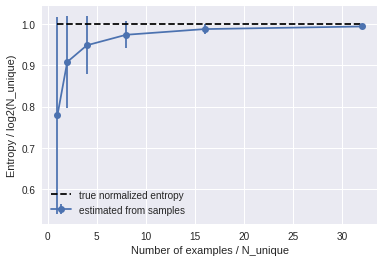

In [0]:
def test_discrete_entropy():
    sizes_normalized = np.power(2, np.arange(6, dtype=int))
    entropy_normalized = defaultdict(list)
    for n_unique_digits in tqdm(np.power(2, np.arange(start=1, stop=10, dtype=int)), desc="Calculating entropy"):
        entropy_true = np.log2(n_unique_digits)
        for size in sizes_normalized:
            for trial in range(20):
                xs = np.random.randint(low=0, high=n_unique_digits, size=size*n_unique_digits)
                entropy = discrete_entropy(xs)
                entropy_normalized[size].append(entropy / entropy_true)
    entropy_mean = [np.mean(entropy_normalized[s]) for s in sizes_normalized]
    entropy_std = [np.std(entropy_normalized[s]) for s in sizes_normalized]
    plt.errorbar(x=sizes_normalized, y=entropy_mean, yerr=entropy_std, fmt='o-', label='estimated from samples')
    plt.xlabel('Number of examples / N_unique')
    plt.ylabel('Entropy / log2(N_unique)')
    plt.hlines(y=1, xmin=min(sizes_normalized), xmax=max(sizes_normalized), linestyles='dashed', label='true normalized entropy')
    plt.legend()


test_discrete_entropy()

### Entropy-based binning. Decision tree.

#### O-Ring failure analysis

You have a physical system (O-Ring) that breaks at certain temperature $T_{critical}$ that varies from sample to sample. 
For a given range of temperatures $[T_{min}, T_{max}]$, you heated the O-Rring and wrote down whether the ring fails ($Y$) or not ($N$). Find the critical temperature to predict whether the ring fails or not.

![](https://www.easternseals.co.uk/wp-content/uploads/2015/04/epdm-o-ring.jpg)

O-Ring failure | Temperature
--- | ---
Y | 53
Y | 56
Y | 57
N | 63
N | 66
N | 67
N | 67
N | 67
N | 68
N | 69
N | 70
Y | 70
Y | 70
Y | 70
N | 72
N | 73
N | 75
Y | 75
N | 76
N | 76
N | 78
N | 79
N | 80
N | 81


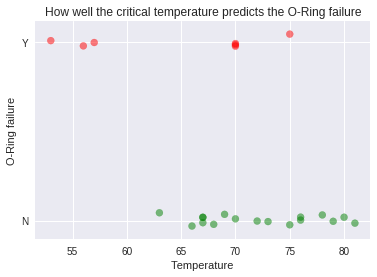

In [0]:
failures = "Y Y Y N N N N N N N N Y Y Y N N N Y N N N N N N"
temperatures = "53 56 57 63 66 67 67 67 68 69 70 70 70 70 72 73 75 75 76 76 78 79 80 81"

failures = np.array(failures.split(), dtype=str)
temperatures = np.array(temperatures.split(), dtype=int)


def visualize_data():
    failures_noisy = (failures == 'Y').astype(float) + 0.02 * np.random.randn(len(failures))
    colors = np.full(failures.shape, 'green', dtype=str)
    colors[failures == 'Y'] = 'red'
    plt.scatter(temperatures, failures_noisy, c=colors, alpha=0.5)
    plt.yticks(ticks=[0, 1], labels=['N', 'Y'])
    plt.xlabel('Temperature')
    plt.ylabel('O-Ring failure')
    plt.title('How well the critical temperature predicts the O-Ring failure')
    plt.show()


visualize_data()

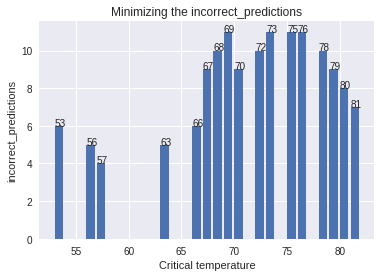

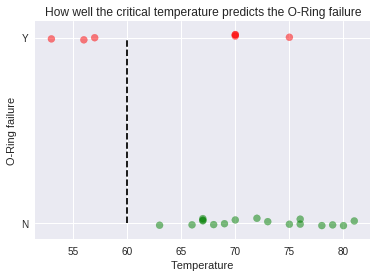

In [0]:
# A naive approach is to count how many times we make incorrect predictions 
# about our assumption that T < T_critical explains the data perfectly.


def incorrect_predictions(t_critical):
    """
    :param t_critical: critical temperature
    :return: number of incorrect predictions
    """
    cold = temperatures <= t_critical
    hot = ~cold
    error_cold_fails = np.sum(failures[cold] != 'Y') + np.sum(failures[hot] != 'N')
    error_hot_fails = np.sum(failures[cold] != 'N') + np.sum(failures[hot] != 'Y')
    error = min(error_cold_fails, error_hot_fails)
    return error


def minimize_objective_function(objective_function=incorrect_predictions):
    """
    :param objective_function: objective function that we want to minimize 
    """
    errors = []
    temperatures_unique = np.unique(temperatures)

    for t_critical in temperatures_unique:
        loss = objective_function(t_critical)
        errors.append(loss)

    plt.bar(temperatures_unique, errors, align='edge')
    plt.xlabel('Critical temperature')
    plt.ylabel(objective_function.__name__)
    plt.title(f'Minimizing the {objective_function.__name__}')
    for temperature, entropy_bar in zip(temperatures_unique, errors):
        plt.text(temperature, entropy_bar, str(temperature))
    plt.show()


minimize_objective_function(objective_function=incorrect_predictions)

plt.vlines(x=60, ymin=0, ymax=1, linestyles='dashed')
visualize_data()


And it works fine. From the plot above, we can conclude that any temperature in range $[57, 63)$ can be used as the critical temperature $T_{critical}$ that splits the data most efficiently. The problem arises when we add other explanatory variables to our data. For example, we might conclude that the ring radius (or material type - categorical variable) also plays a role in the ring failure. One way to cluster such data is by building a decision tree. The question then arises: what branch should we split the data first - by the temperature $T<T_{critical}$ and then by the radius $R<R_{critical}$ or vice versa? Besides making correct predictions, we want to ask our classifier as few YES-or-NO questions as possible. When the data have many explanatory variables, we want to select the most informative ones and the rest variables might turn out to be a pure function of the selected explanatory variables.

The example shown here is taken from https://www.saedsayad.com/supervised_binning.htm.

Intuitively, once the data is clustered (above $T_{critical}$ versus below $T_{critical}$), we want all the data in one cluster correspond to the same label (whether all rings failed or not). In general, we want the conditional distribution $p(data\ in\ cluster\ A|cluster\ A)$ to be a highly peaked function around $cluster\ A$ such that the cluster perfectly defines the data class. That means, we want to minimize the conditional entropy $H(data|cluster)$. In our case, we minimize $H(Failure|TemperatureCluster)$, where

TemperatureCluster | Temperature interval
--- | ---
cold | $T \le T_{critical}$
hot | $T > T_{critical}$

Conditional entropy $H(Failure|TemperatureCluster)$ is the entropy of conditional distribution $p(Failure|TemperatureCluster=c)$, weighted by the cluster size $p(TemperatureCluster=c)$:

$$H(Failure|TemperatureCluster) = \sum_{c\ \in\ \{cold,\ hot\}} p(TemperatureCluster=c) \cdot H(Failure|TemperatureCluster=c) \\ = \sum_{c\ \in\ \{cold,\ hot\}} p(TemperatureCluster=c) \cdot \sum_{f\ \in\ \{Y,\ N\}} p(Failure=f|TemperatureCluster=c)$$

where $p(TemperatureCluster=c)$ is the size of the cluster $c$, divided by the total number of samples.

If we choose $T_{critical}=60$,

<TABLE>
<TR><TH rowspan="2"><TH colspan="2">O-Ring Failure
<TR><TH>Y<TH>N
<TR><TH>Temperature <= 60 <TD>3<TD>0
<TR><TH>Temperature > 60 <TD>4<TD>17
</TABLE>

$$H(Failure|TemperatureCluster)=p(T \le 60) \cdot H_2(p(Y)={0 \over 3}) + p(T>60) \cdot H_2(p(Y)={4 \over 21}) \\ = {3 \over 24} \cdot 0 + {21 \over 24} \cdot 0.7 = 0.615$$

$H_2(p(Y))$ is calculated, using formula $(3)$.
    
We can try different values of $T_{critical}$ and find the best that minimize the conditional entropy above.


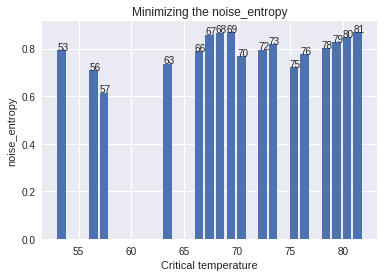

In [0]:
def noise_entropy(t_critical):
    """
    Conditional entropy is sometimes called the 'noise entropy' that quantifies the variability
    of the observed data (ring failures), given the fixed temperature.

    :param t_critical: critical temperature
    :return: noise entropy H(Failure|Temperature)
    """
    cold = temperatures <= t_critical
    hot = ~cold
    entropy_cold = discrete_entropy(failures[cold]) * np.mean(cold)
    entropy_hot = discrete_entropy(failures[hot]) * np.mean(hot)
    return entropy_cold + entropy_hot

minimize_objective_function(objective_function=noise_entropy)

The described entropy-based binning algorithm is called _maximum information gain_ because the entropy of the ring failure $H(Failure)$ is a constant 

<TABLE>
<TR><TH colspan="2">O-Ring Failure
<TR><TH>Y<TH>N
<TR><TD>7<TD>17
</TABLE>

$$H(Failure)=H_2(p(Y)={7 \over 24})=0.871$$ 

and what we can do is just minimizing the conditional entropy $H(Failure|TemperatureCluster)$. By doing so, we maximize the information gain between the temperature and the ring failure. The information gain is defined as

$$I(Failure; Temperature) = H(Failure) - H(Failure|Temperature)$$

And that is the _mutual information_ between two random variables - ring failure and temperature. In our case, it's equal to $0.871 - 0.615 = 0.256$ bits.
